In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from scipy.spatial.transform import Rotation as Rot
import scipy.optimize

In [2]:
f = open("M1.txt", "r")

#the complete file can be split into its sections by splitting on "#"
#using generators for memory/ease of inspecting one element at a time
sections = (section for section in f.read().strip().split("#\n") if section.strip() != "")

#assign each section to a variable to allow specific processing for each
headerlines = next(sections).strip().split("\n")
intensitylines = next(sections).split("\n")
phaselines = next(sections).strip("#\n").split("\n")



#no general loop will be helpful here due to specific formatting
#the data has been simplified enough to step through each line, then each chunk of each line
#to assign to variables by splitting the chunks into their individual parts without whitespaces interfering

#step forward by one, the first line is the single string constant
d = (line.split("\"") for line in headerlines)
stringconstant = next(d)[0]

#step through each chunk and process as required for the fields we need (compare to Metropro documentation)
#several fields will need to be converted to int or float types
#do this by list comprehension on each 'n' in the relevant chunk.split
chunk = next(d)  # - line 2
softwareType, majorVersion, minorVersion, bugVers = [int(n) for n in chunk[0].split()]
softwareDate = chunk[1]

chunk = next(d)  # - line 3
intensOriginX, intensOriginY, intensWidth, intensHeight, Nbuckets, intensRange = [int(n) for n in chunk[0].split()]

chunk = next(d)  # - line 4
phaseOriginX, phaseOriginY, phaseWidth, phaseHeight = [int(n) for n in chunk[0].split()]

chunk = next(d)  # - line 5 (comments)
comments = chunk[1]

chunk = next(d)  # - line 6
partSerNum = chunk[1]
chunk = next(d)  # - line 7
partNum = chunk[1]

chunk = next(d)  # - line 8
source, intfScaleFactor, wavelengthIn, numericAperture, obliquityFactor, magnification, cameraRes, timeStamp = [float(n) for n in chunk[0].split()]

chunk = next(d)  # - line 9
cameraWidth, cameraHeight, systemType, systemBoard, systemSerial, instrumentId = chunk[0].split()
objectiveName = chunk[1]

chunk = next(d)  # - line 10
acquireMode, intensAvgs, PZTCal, PZTGain, PZTGainTolerance, AGC, targetRange, lightLevel, minMod, minModPts = chunk[0].split()

chunk = next(d)  # - line 11
phaseRes, phaseAvgs, minimumAreaSize, disconAction, disconFilter, connectionOrder, removeTiltBias, dataSign, codeVType = chunk[0].split()

chunk = next(d)  # - line 12
subtractSysErr, sysErrFile = chunk[0], chunk[1]

chunk = next(d)  # - line 13
refractiveIndex, partThickness = chunk[0].split()

chunk = next(d)  # - line 14
zoomDesc = chunk[1]

In [3]:
#how to read intensities
#files written 10 values in a line
#will be reshaping to fit the dimensions needed, so easiest to reduce to individual values stored in a single list
#then convert to a numpy array and reshape to suit the dimensions from the header
intensityrows = []
for row in intensitylines:
    for val in row.split():
        intensityrows.append(val)
        
intensitymap = np.array(intensityrows, dtype=float)
intensrows = intensHeight
intenscols = intensWidth
intensitymap = intensitymap.reshape(intensrows,intenscols)

#same process applies to phase data
phaserows = []
for row in phaselines:
    for val in row.split():
        phaserows.append(val)
        
phasemap = np.array(phaserows, dtype=float)
phaserows = phaseHeight
phasecols = phaseWidth
phasemap = phasemap.reshape(phaserows,phasecols)



#true/false array to mark invalid values (>= 64512 as given in manual)
#(can invert true/false if needed by 1 - intensitymask)
#will use the mask to set nan values in the original map (though map needs to be float array not int to allow this)
#then use the colormap properties to decide how to show these values, distinct from the colour scheme for regular values
#so they do not dominate the scaling of values we want to see
intensitymask = intensitymap >=64512
intensitymap[intensitymask == True] = np.nan

#for phasemap (invalid values are >= 2147483640 as given in manual)
phasemask = phasemap >= 2147483640
phasemap[phasemask == True] = np.nan

#convert to waves/heights as described in manual
#where R has one of two possible values indicated by 0/1 phaseRes field
if phaseRes == 0:
    R = 4096
else:
    R = 32768
waves = phasemap*((intfScaleFactor*obliquityFactor)/R)
heights = waves*wavelengthIn

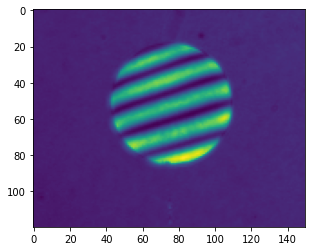

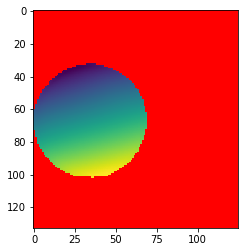

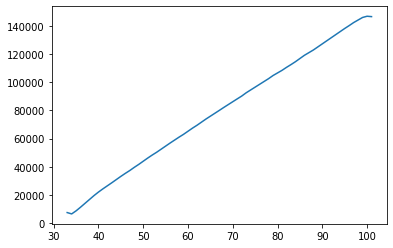

In [4]:
#use the set_bad method of current_cmap to set colour for NaN values
#alpha value can be set also (scaling factor of some sort, not too clear)
#need to set up seperate colour maps otherwise the same one will be used
#can use set_over to limit values but still affected data by magnitude difference
#so better to use set_bad, and set for each plot

current_cmap = copy.copy(cm.get_cmap("viridis"))
# current_cmap.set_over(color="red", alpha=1)
im1 = plt.imshow(intensitymap[120:,:150], cmap=current_cmap)
im1.cmap.set_bad("red", alpha=1)
plt.show()


current_cmap = copy.copy(cm.get_cmap("viridis"))
im2 = plt.imshow(phasemap, cmap=current_cmap)
im2.cmap.set_bad("red", alpha=1)
plt.show()

plt.plot(phasemap[:,30])
plt.show()

In [1]:
#extracting height max and min for flatness measurements
#np.nanmin/np.nanmax extracts the min/max data with NaN excluded
peak = np.nanmax(heights)
valley = np.nanmin(heights)
peakvalley = peak - valley
print(peakvalley)


fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
ax.set_zlim(valley, peak)
X,Y = np.arange(0, heights.shape[0]), np.arange(0, heights.shape[1])
x,y = np.meshgrid(X,Y)

current_cmap = copy.copy(cm.get_cmap("viridis"))
p = ax.plot_surface(x,y, heights.T, antialiased=False, vmin=valley, vmax=peak, cmap=current_cmap)
p.cmap.set_bad("black", alpha=1)

# cbax = fig.add_axes([])
ax.view_init(elev=20, azim=-20)
fig.colorbar(p, orientation="vertical", shrink=0.8, pad=0.16)

plt.show()
# fig.savefig("unrotated.png")

NameError: name 'np' is not defined

2.2357025146484375


/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


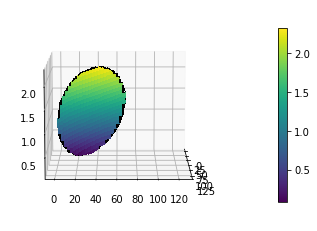

In [6]:

peak = np.nanmax(waves)
valley = np.nanmin(waves)
print(peak - valley)

fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
# ax.set_zlim(valley,peak)
X,Y = np.arange(0, waves.shape[0]), np.arange(0, waves.shape[1])
x,y = np.meshgrid(X,Y)

current_cmap = copy.copy(cm.get_cmap("viridis"))
p = ax.plot_surface(x,y, waves.T, antialiased=False, vmin=valley, vmax=peak, cmap=current_cmap)
p.cmap.set_bad("black", alpha=1)
# cset = ax.contour(x, y, waves.T, zdir='z', offset=-peak, cmap="viridis")
ax.view_init(elev=10, azim=0)

# cbax = fig.add_axes([])
fig.colorbar(p, orientation="vertical", shrink=0.8, pad=0.16)
plt.show()

In [7]:
print(x.shape)
print(y.shape)
print(heights.shape)
print(waves.shape)

(125, 133)
(125, 133)
(133, 125)
(133, 125)


In [8]:
rmsHeight = np.sqrt(np.nanmean(heights**2))
rmsHeight

8.693560666579604e-07

##### Rotating to remove tilt of plane

In [9]:
#basic idea of approach: rotating to remove tilt
#the tilt causes the scale at surface level to be dominated by the peak-valley height
#so essentially want to reduce the peak-valley height to a minimum -> optimisation
#define a function which operates combined x & y rotations on the surface (interpolated?) and returns peak-valley height
#then use scipy optimise with the function
#I believe the optimisation can work with generic functions so long as the input and outputs fit certain requirements
#set up function to take the array values (create a surface from them ?), and also initial angles to attempt (leave as 0 ?)
#how does optimize work with parameters into f vs into optimize itself?

In [10]:
#function to be minimised
#assuming an input array with 2D grid of height values
#to be converted into position vectors from the i,j index and value, i.e. [x=i,y=j,z=value]
#will probably change to more general co-ordinates centred at (0,0) rather than only in the positive plane
#need more than the heights to rotate but only want to extract the height for easy peak-valley calculation
def testf(*args):
    angx, angy = args[0]
    array = args[1]
    dims = array.shape
    x,y = np.indices(dims)  # - this line would change or be shifted to centre at 0,0
        
    #define rotations in x and y respectively and combine with * operation
    rx = Rot.from_rotvec(angx*np.array([1,0,0]))
    ry = Rot.from_rotvec(angy*np.array([0,1,0]))
    r = rx*ry
    
    #make the array of position vectors in (Nx3) format: i.e. [x,y,height] as one element
    vectarray = np.dstack([x,y,array])
    vectarray = vectarray.reshape(int(vectarray.size/3), 3)
    
    #apply overall rotation to the entire vector array (rotates each vector individually)
    #then extract back the individual columns and store them with the original array shape
    newarray = r.apply(vectarray)
    xs = newarray[:,0].reshape(dims)
    ys = newarray[:,1].reshape(dims)
    zs = newarray[:,2].reshape(dims)
    
#     peakvalley = np.nanmax(zs) - np.nanmin(zs)
    sqdeviation = np.nansum(array**2)
    
    
    
#     print(angx,angy)
#     print("\t",np.argmax(heights),np.argmin(heights))
    
    return sqdeviation

In [11]:
sqd = (heights)**2
np.nansum(sqd)

2.9407398657407854e-09

In [12]:
opts = {"ftol":1e-15, "xtol":1e-15, "maxiter":1000}
params = scipy.optimize.minimize(testf, x0=[0,0], args=heights, tol=1e-15, method="Nelder-Mead",options=opts)
optimalangles = params["x"]
params

 final_simplex: (array([[0.00000000e+00, 0.00000000e+00],
       [9.09494702e-16, 0.00000000e+00],
       [0.00000000e+00, 9.09494702e-16]]), array([2.94073987e-09, 2.94073987e-09, 2.94073987e-09]))
           fun: 2.9407398657407854e-09
       message: 'Optimization terminated successfully.'
          nfev: 155
           nit: 39
        status: 0
       success: True
             x: array([0., 0.])

In [13]:
#adjusting array into vectors to then apply rotation (same system used in testf - make function for this?)
#"grid" is the array of position vectors: [x,y,heights]
dims = heights.shape
x,y = np.indices(dims)

grid = np.dstack([x,y,heights])
grid = grid.reshape(int(grid.size/3), 3)

In [14]:
#rotating the height with the found angles which reduce the peak-valley height
#using "heights1" name during initial tests, so not overwriting the read-in array "heights"
angx,angy = optimalangles

rotx = Rot.from_rotvec(angx*np.array([1,0,0]))
roty = Rot.from_rotvec(angy*np.array([0,1,0]))
rot = rotx*roty

grid = rot.apply(grid)
xs = grid[:,0].reshape(dims)
ys = grid[:,1].reshape(dims)
heights1 = grid[:,2].reshape(dims)
print(np.nanmax(heights1) - np.nanmin(heights1))

grid

1.4147525512695313e-06


array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  # This is added back by InteractiveShellApp.init_path()


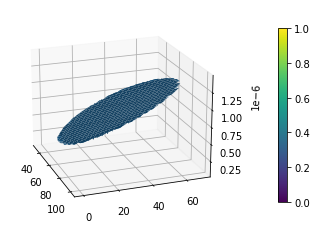

In [15]:
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
# ax.set_xlim(-2,2)
# ax.set_ylim(-2,2)
ax.set_zlim(np.nanmin(heights1),np.nanmax(heights1))

# cset = ax.contour(xs,ys,heights, zdir="y", offset=103)

ax.view_init(elev=20, azim=-20)
p = ax.plot_surface(xs,ys,heights1, antialiased=True)
fig.colorbar(p, orientation="vertical", shrink=0.8, pad=0.16)
plt.show()
# fig.savefig("rotated1.png")

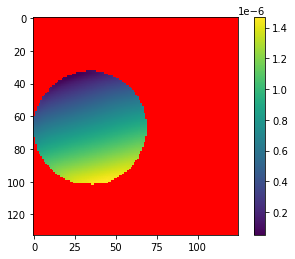

In [16]:
current_cmap = copy.copy(cm.get_cmap("viridis"))
imr = plt.imshow(heights1, cmap=current_cmap)
imr.cmap.set_bad("red", alpha=1)
plt.colorbar()
plt.show()

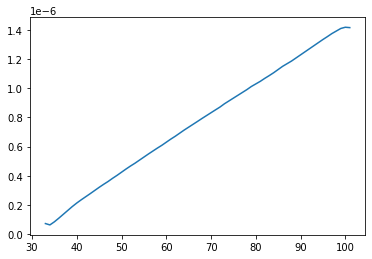

In [17]:
plt.plot(heights1[:,30])
plt.show()

In [18]:
# rmsHeight = np.sqrt(np.nanmean(heights1**2))
peakvalley = np.nanmax(heights1) - np.nanmin(heights1)
print("Peak to Valley height: ",peakvalley,"m")
# print("RMS height: ",rmsHeight,"m")

Peak to Valley height:  1.4147525512695313e-06 m


#### Cropping/centring maps

In [19]:
#remove edge effects by cropping to a certain radius first
#then center view on selected data (not centred co-ordinates yet)
#idea: select the known values (where not nan/ where "isfinite")
#check for the valid indexes which fall outside the radius check
#with these points identified, can adjust original array at these points and/or construct new array
validrows, validcols = np.where(np.isfinite(heights1))
centre = int(np.nanmean(validrows)), int(np.nanmean(validcols))  # - note this is y,x order at moment (can change)

lft, rgt, upp, low = np.nanmin(validcols), np.nanmax(validcols), np.nanmin(validrows), np.nanmax(validrows)

#now apply radial check
radius = 25
(validrows - centre[0])**2 + (validcols - centre[1])**2 > radius**2

array([ True,  True,  True, ...,  True,  True,  True])

In [20]:
h2 = heights1[:]
mask = (validrows - centre[0])**2 + (validcols - centre[1])**2 > radius**2
# h2[mask] = 1
# mask.reshape(heights1[])
# heights1[validrows,validcols]
# h2[h2]

In [21]:
y,x = np.ogrid[0:heights1.shape[0], 0:heights1.shape[1]]  # - don't need ogrid format, can use np.indices and get same mask

validrows, validcols = np.where(np.isfinite(heights1))
centre = int(np.nanmean(validrows)), int(np.nanmean(validcols))  # - note this is y,x order at moment (can change)
radius = 30
outsideR = (x - centre[1])**2 + (y - centre[0])**2 > radius**2
cropped = heights1[:]
cropped[outsideR] = np.nan

In [22]:
opts = {"ftol":1e-15, "xtol":1e-15, "maxiter":1000}
params = scipy.optimize.minimize(testf, x0=[0,0], args=cropped, tol=1e-15, method="Nelder-Mead",options=opts)
optimalangles = params["x"]
params

 final_simplex: (array([[0.00000000e+00, 0.00000000e+00],
       [9.09494702e-16, 0.00000000e+00],
       [0.00000000e+00, 9.09494702e-16]]), array([2.0292108e-09, 2.0292108e-09, 2.0292108e-09]))
           fun: 2.02921079874235e-09
       message: 'Optimization terminated successfully.'
          nfev: 155
           nit: 39
        status: 0
       success: True
             x: array([0., 0.])

In [23]:
dims = cropped.shape
x,y = np.indices(dims)

grid = np.dstack([x,y,cropped])
grid = grid.reshape(int(grid.size/3), 3)
angx,angy = optimalangles

rotx = Rot.from_rotvec(angx*np.array([1,0,0]))
roty = Rot.from_rotvec(angy*np.array([0,1,0]))
rot = rotx*roty

grid = rot.apply(grid)
xs = grid[:,0].reshape(dims)
ys = grid[:,1].reshape(dims)
cropped = grid[:,2].reshape(dims)

In [24]:
#centring in z axis

cropped -= np.nanmean(cropped)  # - centring in z, around the mean

In [25]:
validrows, validcols = np.where(np.isfinite(cropped))
lft, rgt, upp, low = np.nanmin(validcols), np.nanmax(validcols), np.nanmin(validrows), np.nanmax(validrows)
cropped1 = cropped[upp:low+1, lft:rgt+1]
# heights1 = heights1[upp:low+1, lft:rgt+1]

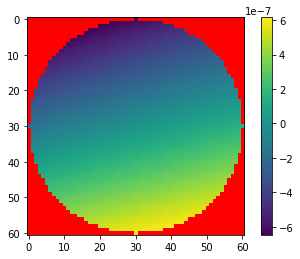

In [26]:
current_cmap = copy.copy(cm.get_cmap("viridis"))
imr = plt.imshow(cropped1, cmap=current_cmap)
imr.cmap.set_bad("red", alpha=1)
plt.colorbar()
plt.show()

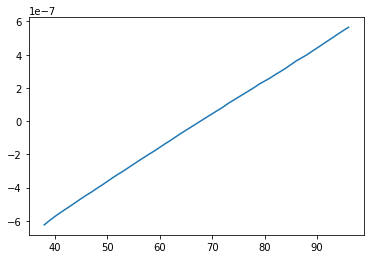

In [27]:
#improved cross-section
plt.plot(cropped[:,30])
# plt.plot(cropped[30:,])  # - idk what this is
plt.show()

/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


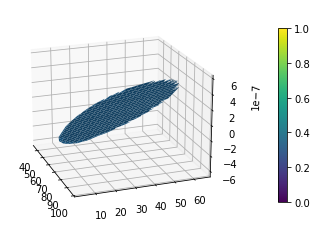

In [28]:
#plots for cropped map, new rotations found without edge defects
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
# ax.set_xlim(-2,2)
# ax.set_ylim(-2,2)
ax.set_zlim(np.nanmin(cropped),np.nanmax(cropped))

# cset = ax.contour(xs,ys,heights, zdir="y", offset=103)

ax.view_init(elev=20, azim=-20)
p = ax.plot_surface(xs,ys,cropped, antialiased=True)
fig.colorbar(p, orientation="vertical", shrink=0.8, pad=0.16)
plt.show()

In [29]:
#rms calculation having accounted for offset
rmsHeight = np.sqrt(np.nanmean((cropped)**2))
rmsHeight

3.1252278580057715e-07

In [30]:
#peakvalley
peakvalley = np.nanmax(cropped) - np.nanmin(cropped)
peakvalley

1.2634853881835937e-06